### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [ ]:
import requests

# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}

In [ ]:
print(list(labels.items())[:5])

[(0, 'tench'), (1, 'goldfish'), (2, 'great white shark'), (3, 'tiger shark'), (4, 'hammerhead shark')]


### TorchVision


We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)


In [ ]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-1.0941,  0.9064,  1.8090,  ..., -2.0825, -0.6753,  1.5401],
        [-1.1298,  1.0398,  1.6457,  ..., -2.0848, -0.2542,  1.7015],
        [-1.2090,  1.0555,  1.4699,  ..., -1.8965, -0.2051,  1.7207],
        [-1.4565,  0.8481,  1.5064,  ..., -1.9939, -0.3392,  1.6880],
        [-1.2626,  0.5746,  1.6911,  ..., -2.1166, -0.5058,  1.3498]],
       grad_fn=<AddmmBackward0>)

### Predict class probabilities

In [ ]:
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2022-10-17 12:30:42--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2022-10-17 12:30:42 (99.1 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



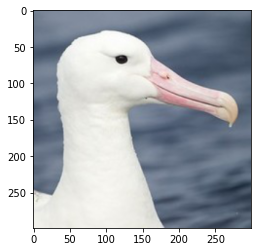

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland Sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	duck
0.0003 :	hammerhead shark
0.0003 :	nipple
0.0003 :	Polaroid camera


In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [ ]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2022-10-17 12:30:45--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.21.61.15, 172.67.204.223, 2606:4700:3035::ac43:ccdf, ...
Connecting to cdn.com.do (cdn.com.do)|104.21.61.15|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2022-10-17 12:30:45--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.21.61.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0s      

2022-10-17 12:30:45 (127 MB/s) - ‘img.jpg’ saved [51048/51048]



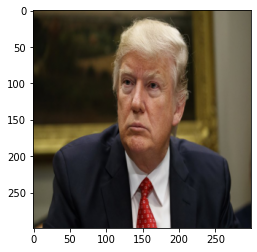

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	bridegroom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	slip-on shoe
0.0032 :	wig
0.0028 :	Afghan Hound
0.0027 :	bow tie


In [ ]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Main objective
* Goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
#!wget -nc https://disk.yandex.ru/d/nuyCNaDrE1Bq0w -O dogs_vs_cats.train.zip
# if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
#!unzip -n data.zip

In [ ]:
!unzip -n dogs_vs_cats.train.zip

Archive:  dogs_vs_cats.train.zip


### Get features


In [ ]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x #do nothing
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

In [ ]:
embedding(transform_input(img)).data.numpy()

array([[0.13746059, 0.16949922, 0.19832008, ..., 0.17791326, 0.3367856 ,
        0.40053278]], dtype=float32)

# for starters
* Train sklearn model, evaluate validation accuracy 

In [ ]:
#extract features from images
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 512
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor).data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

In [ ]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24960, 2048) (24960,)


In [ ]:
np.save('X.npy',X)
np.save('Y.npy',Y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state=17,shuffle=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## LogisticRegression

In [ ]:
clf = LogisticRegressionCV(cv=5,random_state=10,n_jobs=-1,Cs=[0.001, 0.01, 0.1, 1, 10, 100],scoring='accuracy')
clf.fit(X_train, y_train)
print("Результат по accuracy для регрессии средний на кросс-валидации --> " + str(clf.scores_[1].mean(axis=0).max()))

Результат по accuracy для регрессии --> 0.9876300175281705


In [ ]:
print("Результат по accuracy для регрессии на тестовой выборке --> " + str(accuracy_score(y_test,clf.predict(X_test))))

Результат по accuracy для регрессии на тестовой выборке --> 0.9931891025641025


## Random Forest

In [ ]:
random_forest = RandomForestClassifier(random_state=17,n_jobs=-1, n_estimators=300)
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=17)

In [ ]:
print("Результат по accuracy Random forest на тестовой выборке --> " + str(accuracy_score(y_test,random_forest.predict(X_test))))

Результат по accuracy Random forest на тестовой выборке --> 0.9879807692307693


## Fine-tuning

Попытка добавить новые слои прямо в модель

In [ ]:
from torchvision import models, transforms

In [ ]:
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    X.append(fname)
    
    index += 1

100%|██████████| 25000/25000 [00:00<00:00, 1452019.66it/s]


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=5000, random_state=17,shuffle=True)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=5000, random_state=17,shuffle=True)

In [ ]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = embedding(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
embedding.add_module('dense_head', nn.Linear(2048, 64))
embedding.add_module('dense_head_relu', nn.ReLU())
embedding.add_module('final', nn.Linear(64, 2))

In [ ]:
head_only = [
        {'params': embedding.dense_head.parameters(), 'lr': 1e-3},
        {'params': embedding.final.parameters(), 'lr': 1e-3}
        ]

opt = torch.optim.Adam(head_only, lr=0.001)

train_loss = []
val_accuracy = []

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_valid = np.asarray(X_valid)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_valid = np.asarray(y_valid)

In [ ]:
import time
num_epochs = 50 # total amount of full passes over training data
batch_size = 32  # number of samples processed in one SGD iteration
valid_max = 0
valid_iter = 0

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    
    model.train(True)
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        X_batch_tensors = np.zeros([batch_size, 299, 299, 3])
        i = 0
        for fname in X_batch:
          img = imread(os.path.join("train", fname))
          img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
          X_batch_tensors[i] = img
          i+= 1

        X_batch = torch.as_tensor(X_batch_tensors.transpose([0,3,1,2]), dtype=torch.float32)

        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_valid, y_valid, batch_size):

        X_batch_tensors = np.zeros([batch_size, 299, 299, 3])
        i = 0
        for fname in X_batch:
          img = imread(os.path.join("train", fname))
          img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
          X_batch_tensors[i] = img
          i+= 1

        X_batch = torch.as_tensor(X_batch_tensors.transpose([0,3,1,2]), dtype=torch.float32)

        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    
    val_accuracy = np.mean(val_accuracy[-len(X_valid) // batch_size :]) * 100

    print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy))
    
    if val_accuracy > valid_max:
      valid_max = val_accuracy
      valid_iter = epoch

    if (epoch - valid_iter) > 10:
      print("Fine-tuning ended")
      break

Новая модель сверху на признаки

In [ ]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=5000, random_state=17,shuffle=True)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=5000, random_state=17,shuffle=True)

In [ ]:
model2 = nn.Sequential()

# dense "head"
model2.add_module('dense1', nn.Linear(2048, 64))
model2.add_module('dense1_relu', nn.ReLU())
model2.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

In [ ]:
opt = torch.optim.Adam(model2.parameters())

train_loss = []
val_accuracy = []

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model2(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 64  # number of samples processed in one SGD iteration
valid_max = 0
valid_iter = 0

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    
    model2.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model2.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_valid, y_valid, batch_size):
        logits = model2(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_valid) // batch_size :]) * 100))

    if (np.mean(val_accuracy[-len(X_valid) // batch_size :]) * 100) > valid_max:
      valid_max = (np.mean(val_accuracy[-len(X_valid) // batch_size :]) * 100)
      valid_iter = epoch

    if (epoch - valid_iter) > 10:
      print("Fine-tuning ended")
      break

Epoch 1 of 100 took 1.348s
  training loss (in-iteration): 	0.020728
  validation accuracy: 			98.54 %
Epoch 2 of 100 took 0.764s
  training loss (in-iteration): 	0.020379
  validation accuracy: 			98.40 %
Epoch 3 of 100 took 0.771s
  training loss (in-iteration): 	0.016973
  validation accuracy: 			98.28 %
Epoch 4 of 100 took 0.794s
  training loss (in-iteration): 	0.018910
  validation accuracy: 			98.26 %
Epoch 5 of 100 took 0.771s
  training loss (in-iteration): 	0.013474
  validation accuracy: 			98.22 %
Epoch 6 of 100 took 0.765s
  training loss (in-iteration): 	0.012724
  validation accuracy: 			98.40 %
Epoch 7 of 100 took 0.768s
  training loss (in-iteration): 	0.011355
  validation accuracy: 			97.90 %
Epoch 8 of 100 took 0.776s
  training loss (in-iteration): 	0.010877
  validation accuracy: 			98.14 %
Epoch 9 of 100 took 0.785s
  training loss (in-iteration): 	0.010183
  validation accuracy: 			98.32 %
Epoch 10 of 100 took 0.760s
  training loss (in-iteration): 	0.014093
  v

На тесте

In [ ]:
np.mean(model2.forward(torch.as_tensor(X_test, dtype=torch.float32)).max(1)[1].data.numpy() == y_test)

0.9898

# Deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
    ])


def dd_helper(image, layer, iterations, lr):
    # поменял чтобы градиент работал
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), dtype=torch.float32).clone().detach().requires_grad_(True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

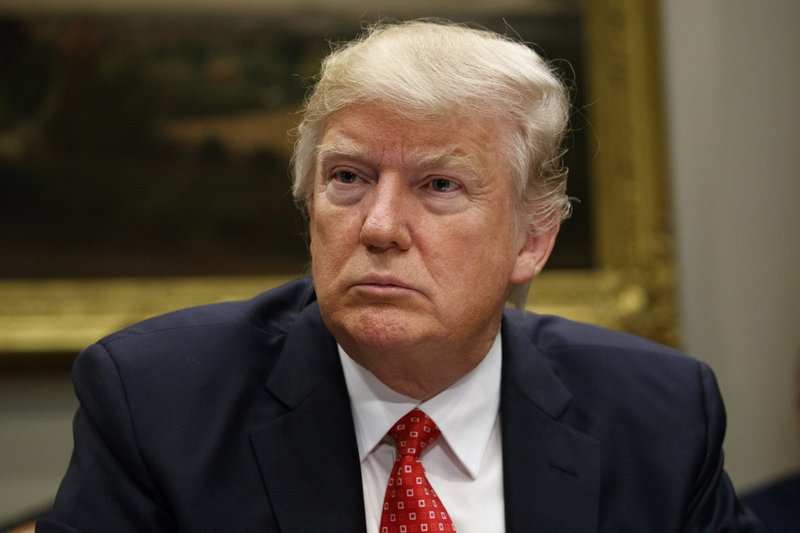

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------
-------------- Recursive level:  6 --------------
-------------- Recursive level:  7 --------------
-------------- Recursive level:  8 --------------
-------------- Recursive level:  9 --------------
-------------- Recursive level:  10 --------------
-------------- Recursive level:  11 --------------
-------------- Recursive level:  12 --------------
-------------- Recursive level:  13 --------------
-------------- Recursive level:  14 --------------
-------------- Recursive level:  15 --------------
-------------- Recursive level:  16 --------------
-------------- Recursive level:  17 --------------
-------------- Recursive level:  18 --------------
-------------- Recursive level:  19 -----

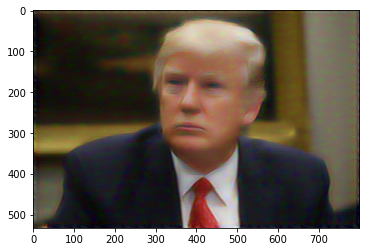

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------


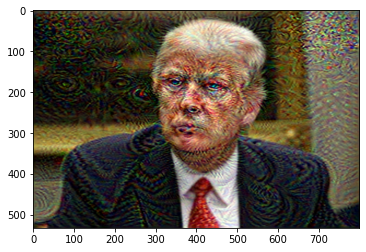

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas

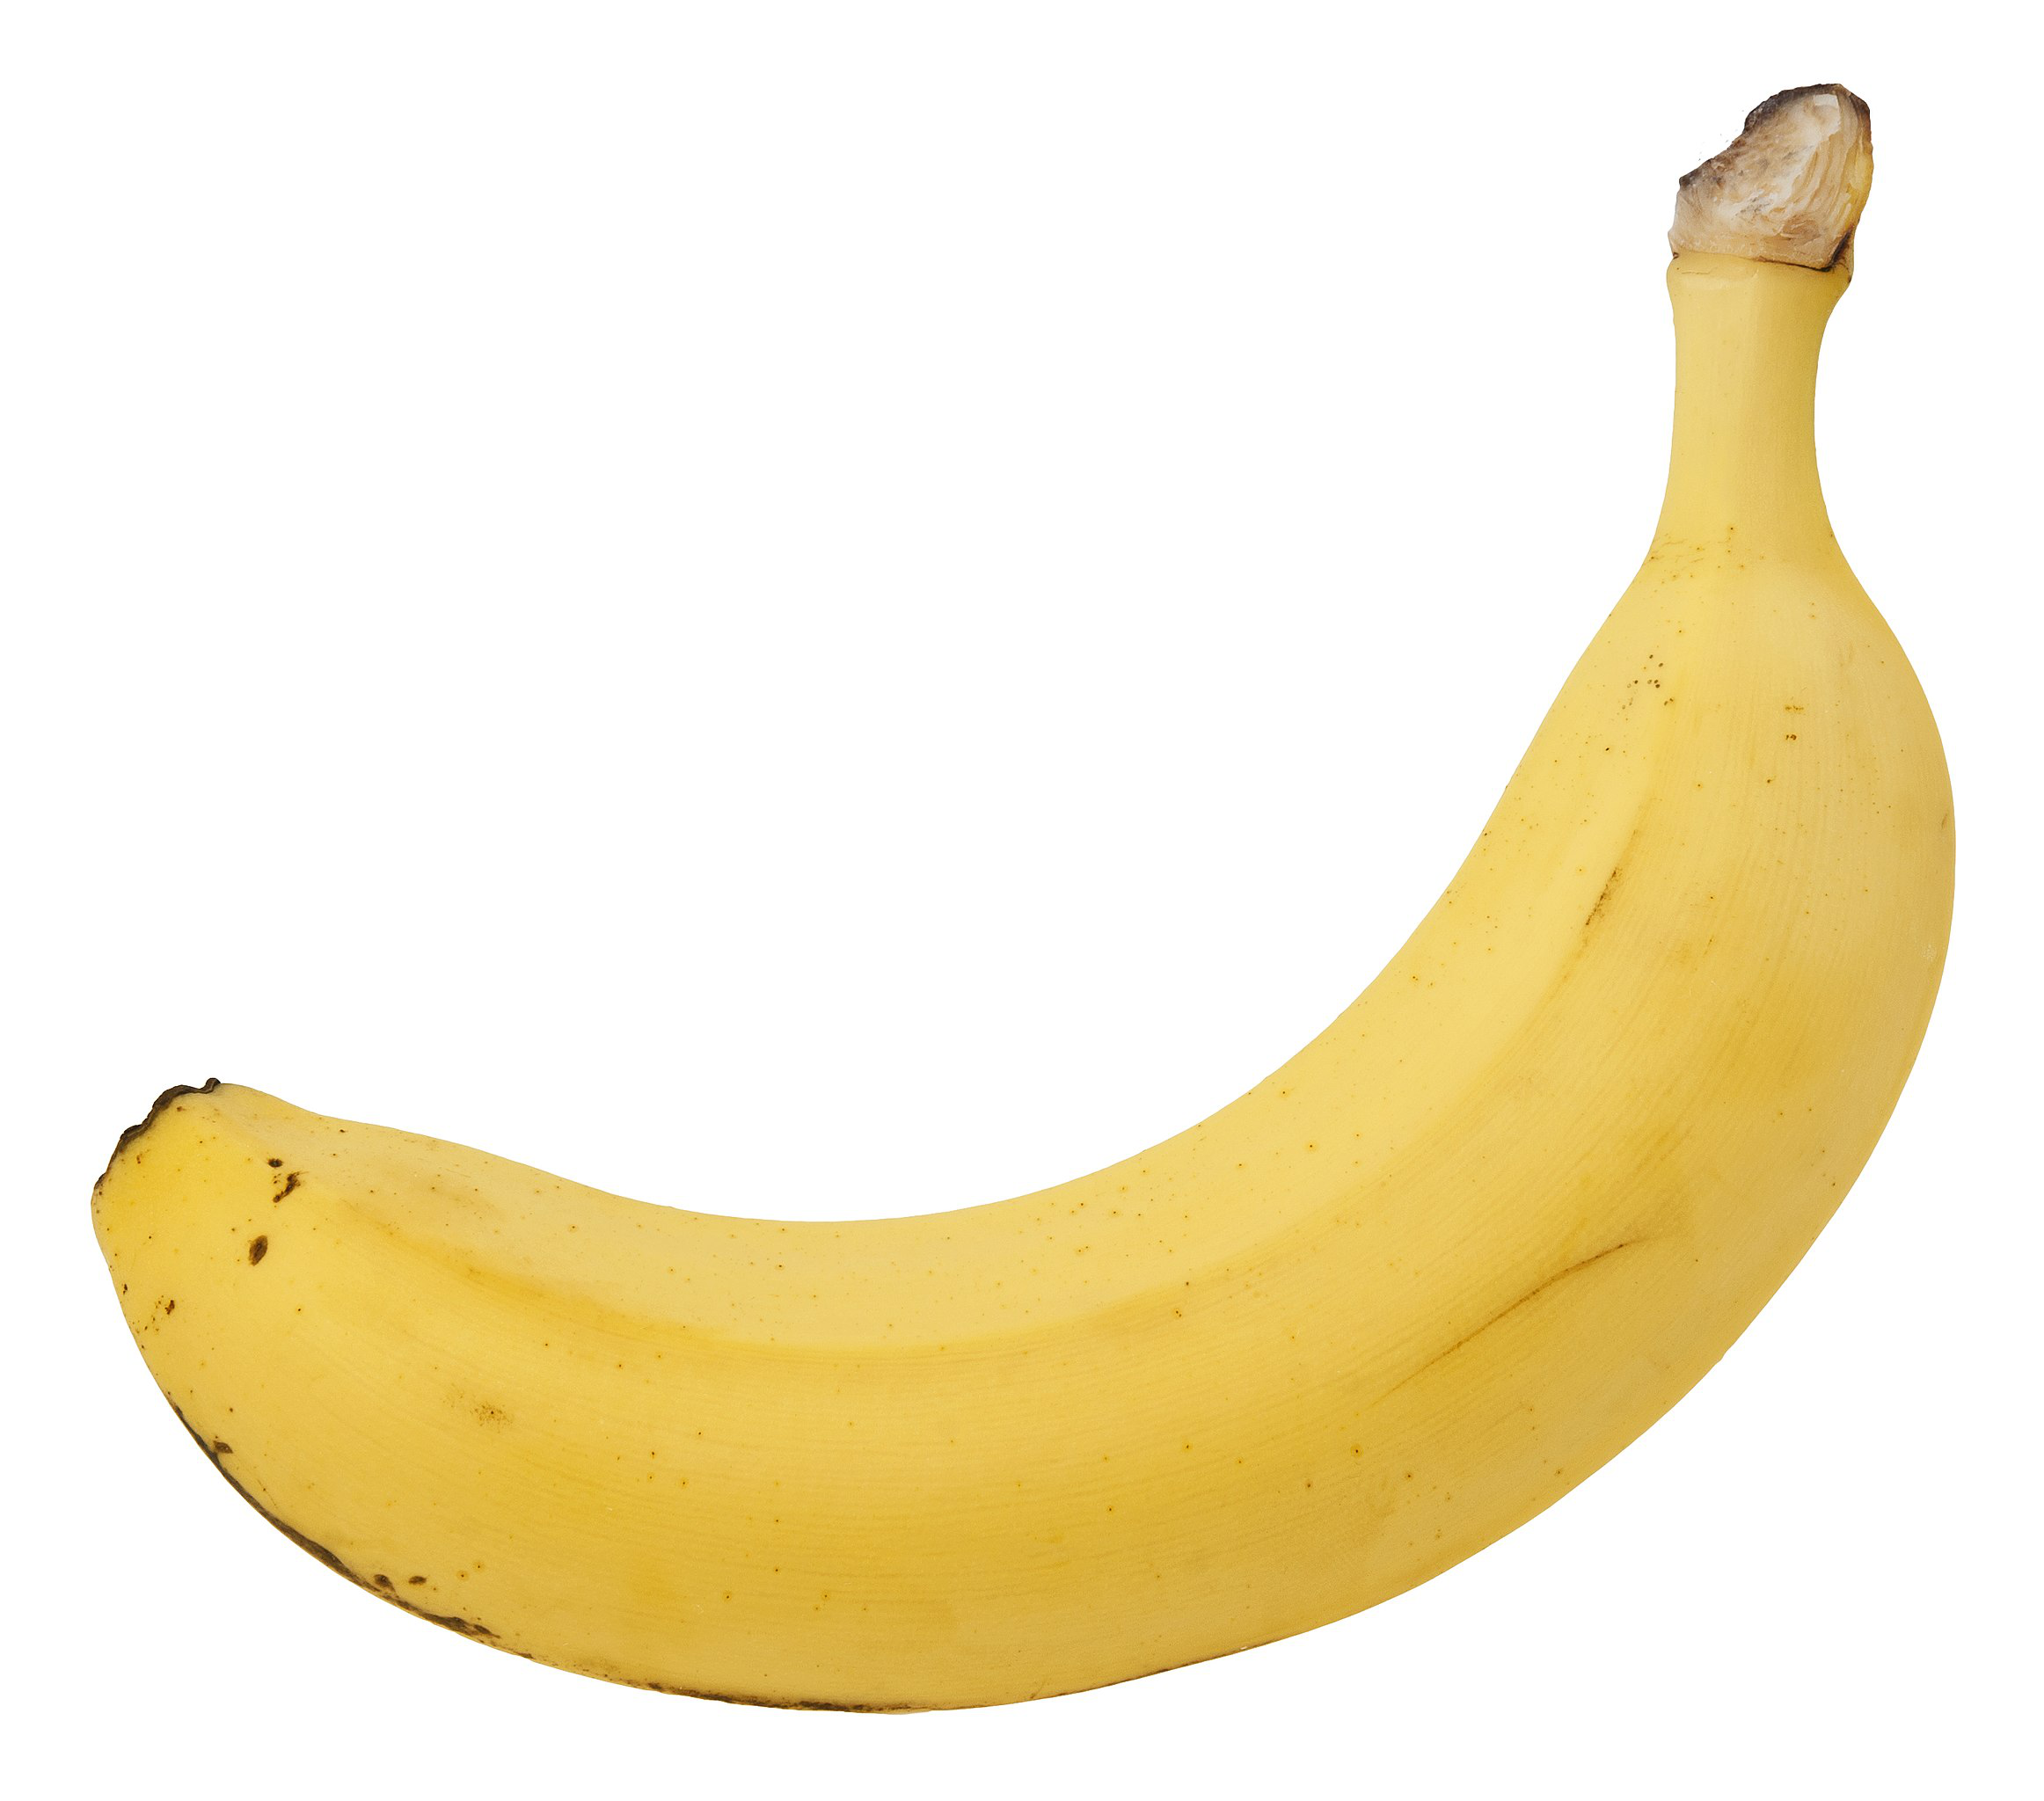

In [ ]:
guide_img = Image.fromarray(plt.imread('banana.jpg'))
guide_img

In [ ]:
guide_var = torch.as_tensor(preprocess(guide_img).unsqueeze(0), dtype=torch.float32).clone().detach().requires_grad_(True)

In [ ]:
def dd_helper(image, layer, iterations, lr, guide_var): #добавляем целевое изображение
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), dtype=torch.float32).clone().detach().requires_grad_(True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        guide_out = guide_var
        for j in range(layer):
            guide_out = modulelist[j](guide_out)
        for j in range(layer):
            out = modulelist[j](out)
        loss = F.cross_entropy(out,guide_out) # ошибка - разница между выходами слоя на нужной картинке и текущей
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves, guide_var ): #передаем guide_var
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1,guide_var)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr, guide_var)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------


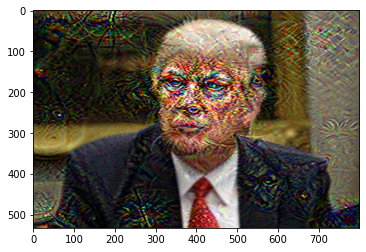

In [ ]:
output_banana = deep_dream(img, 12, 5, 0.2, 2, 1, guide_var)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------
-------------- Recursive level:  6 --------------
-------------- Recursive level:  7 --------------
-------------- Recursive level:  8 --------------
-------------- Recursive level:  9 --------------
-------------- Recursive level:  10 --------------
-------------- Recursive level:  11 --------------
-------------- Recursive level:  12 --------------
-------------- Recursive level:  13 --------------
-------------- Recursive level:  14 --------------
-------------- Recursive level:  15 --------------
-------------- Recursive level:  16 --------------
-------------- Recursive level:  17 --------------
-------------- Recursive level:  18 --------------
-------------- Recursive level:  19 -----

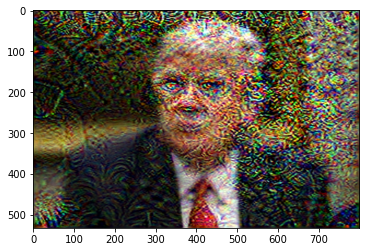

In [ ]:
output_banana = deep_dream(img, 12, 5, 0.2, 2, 20, guide_var)

# Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image

def dd_helper_modified(image, layer, iterations, epsilon):
  
    input_var = torch.as_tensor(preprocess(img).unsqueeze(0), dtype=torch.float32).clone().detach().requires_grad_(True)
    target = model.forward(input_var)
    input_var_min = input_var.min().data
    input_var_max = input_var.max().data

    for i in range(iterations):
        output = model.forward(input_var) #предсказания модели
        loss = F.cross_entropy(F.softmax(output,dim=-1),F.softmax(target,dim=-1))
        loss.backward(retain_graph=True)
        grad = epsilon * torch.sign(input_var.grad.data)
        input_var.data = input_var.data + grad
        model.zero_grad() 

    input_var.data = torch.clamp(input_var.data, input_var_min,input_var_max)
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

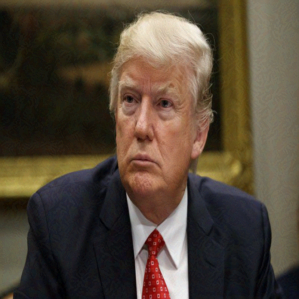

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper_modified(img, 1, 10, 0.001)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))

top-10 classes are: 
 [prob : class label]
0.4315 :	bridegroom
0.0188 :	Windsor tie
0.0117 :	gown
0.0116 :	suit
0.0064 :	rapeseed
0.0060 :	Afghan Hound
0.0047 :	rugby ball
0.0037 :	oboe
0.0037 :	bow tie


In [ ]:
predict(resize(plt.imread('img.jpg'), (299, 299))) # топ классы картинки изначально

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	bridegroom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	slip-on shoe
0.0032 :	wig
0.0028 :	Afghan Hound
0.0027 :	bow tie


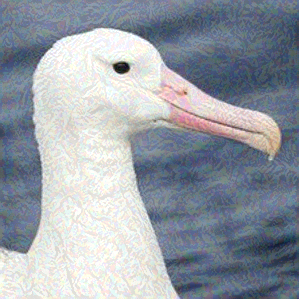

In [ ]:
img = Image.fromarray(plt.imread('sample_images/albatross.jpg'))
img_adv = dd_helper_modified(img, 1, 10, 0.005)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))

top-10 classes are: 
 [prob : class label]
0.0079 :	pelican
0.0060 :	spoonbill
0.0051 :	crane (bird)
0.0049 :	white stork
0.0047 :	black stork
0.0041 :	albatross
0.0040 :	water buffalo
0.0039 :	oystercatcher
0.0039 :	flamingo
